In [1]:
from montu import *
import matplotlib.pyplot as plt
from astropy.time import Time
from astroquery.jplhorizons import Horizons

%load_ext autoreload
%autoreload 2

## Prepare environment

We need to get and connect the files for ephemerides calculation:

In [2]:
# Load SPICE data
Montu.load_kernels()

Loading kernel latest_leapseconds.tls
Loading kernel de441_part-1.bsp


## The stars

The package is provided with a catalogue with all stars between magnitude -1.44 and magnitude 21.

In [3]:
allstars=Stars()

Get Aldebaran position and stars around it:

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: xlabel='RA [deg]', ylabel='Dec [deg]'>)

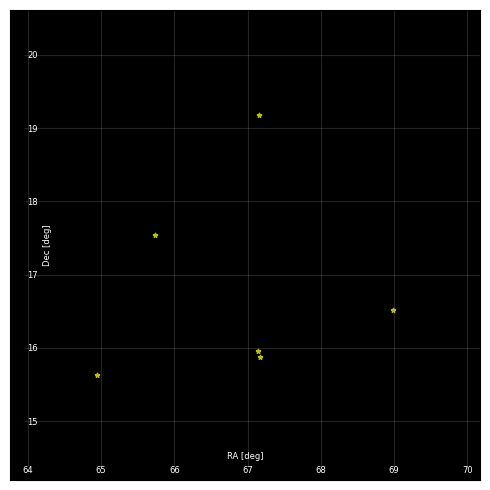

In [4]:
aldebaran = allstars.get_stars(ProperName='Aldebaran')
hyades = allstars.get_stars_area(RA=aldebaran.data.RA,Dec=aldebaran.data.Dec,radius=5,Mag=[-1,4])
hyades.plot_stars(pad=0.1)

## Time issues

`SPICE` works with the Gregorian calendar, so, it is hard to compare dates between 59 b.c. and 1582 a.d.  For instance:

In [5]:
date = '1000 B.C. 09-07 12:00:00'
et = spy.utc2et(date)
dt = spy.deltet(et,"ET")
et -= dt
print(dt)
jd = spy.unitim(et,"ET","JDTDB") 
jd

41.18247463623287


1356432.0

This julian day, however, correspond to september the 16th in the Julian Calendar which is the date assumed in NASA `Horizons` system. If you compute the coordinates of Mars at that date with `SPICE`` you obtain:

In [6]:
X,lt = spy.spkezr('4',et,'J2000','LT+S','399')
r,RA,DEC = spy.reclat(X[:3])
ra = np.mod(RA*RAD,360)/15
jd, Montu.dec2hex(ra), Montu.dec2hex(DEC*RAD)

(1356432.0, (18.0, 30, 29.027181943781954), (-25.0, 31, 5.584286831078487))

Using `astroquery`:

In [7]:
RA,DEC = list(Horizons(id='4',location='399',epochs=jd).ephemerides().to_pandas().loc[0,['RA','DEC']])
Montu.dec2hex(RA/15), Montu.dec2hex(DEC)

((18.0, 31, 25.497600000005036), (-25.0, 30, 27.28800000000291))

Using `Horizons` app you get: RA = 18 30 29.53, DEC = -25 31 04.6. However in `Horizons` the mixed calendar date is September the 16th, 1000 b.c.

In `Stellarium` the same date give us this position for Mars: RA = 18 31 22.81, Dec = -25 30 22.1. Additionally `Stellarium` use a date with negative numbers, so the date corresponding to JD = 1356432 is -999 september the 16th, 12:03:44.

**Conclusions**:
- The results with SPICE nicely agree with HORIZONS provided the date given to Horizons is the JDTDB, not the UTC date.
- The results of astroquery are not as accurate as SPICE.
- The results with Stellarium are off by around 1 arcmin which for the purposes of Cultural Astronomy are not important.

Let's see what happen in `astropy`:

In [8]:
time = Time(jd,format='jd',scale='tt').iso
time

'-999-09-07 12:00:00.000'

A last option is to work with `numpy.datetime64` (see https://numpy.org/doc/stable/reference/arrays.datetime.html):

In [9]:
# date = '1000 B.C. 09-07 12:00:00'
date = '-999-09-07 12:00:00.00'
time = np.datetime64(date)
time

numpy.datetime64('-999-09-07T12:00:00.000')

You may generate arrays of times:

In [10]:
np.arange('-999-02', '-999-03', dtype='datetime64[D]')

array(['-999-02-01', '-999-02-02', '-999-02-03', '-999-02-04',
       '-999-02-05', '-999-02-06', '-999-02-07', '-999-02-08',
       '-999-02-09', '-999-02-10', '-999-02-11', '-999-02-12',
       '-999-02-13', '-999-02-14', '-999-02-15', '-999-02-16',
       '-999-02-17', '-999-02-18', '-999-02-19', '-999-02-20',
       '-999-02-21', '-999-02-22', '-999-02-23', '-999-02-24',
       '-999-02-25', '-999-02-26', '-999-02-27', '-999-02-28'],
      dtype='datetime64[D]')

Or perform operations:

In [11]:
np.datetime64('-999-09-07 12:00:00.00') + np.timedelta64(1,'D')

numpy.datetime64('-999-09-08T12:00:00.000')

**Conclusions**:
- The results with SPICE nicely agree with HORIZONS provided the date given to Horizons is the JDTDB, not the UTC date.
- The results of astroquery are not as accurate as SPICE.
- The results with Stellarium are off by around 1 arcmin which for the purposes of Cultural Astronomy are not important.

### The class `MonTime`

For managing times we have designed a special class `MonTime`. If you provide to the class a simple string in different formats you can obtain many different properties of the time. For instance:

In [12]:
mtime_ini = MonTime('-1470-01-01 12:00:00.00')
print(mtime_ini.__dict__)

{'datestr': '-1470-01-01 12:00:00.00', 'bce': True, 'datetime64': numpy.datetime64('-1470-01-01T12:00:00.000'), 'cal': array([-1.47e+03,  1.00e+00,  1.00e+00,  1.20e+01,  0.00e+00,  0.00e+00,
        0.00e+00]), 'datespice': '1471 B.C. 01-01 12:00:00.0', 'et': -109502582399.99998, 'deltat': 41.185396343449355, 'jd': 1184154.0000000002, 'astrotime': <Time object: scale='tdb' format='jd' value=1184154.0000000002>}


## Planetary ephemerides

In [13]:
p = Planet(id='4')
mtime = MonTime('-999-09-07 12:00:00.00')
print(mtime.jd)
p.calc_ephemerides(mtime.et)

Montu.dec2hex(p.RAJ2000), Montu.dec2hex(p.DECJ2000), Montu.dec2hex(p.lambJ2000), Montu.dec2hex(p.betaJ2000)

1356432.0


((18.0, 30, 29.027181943781954),
 (-25.0, 31, 5.584286831078487),
 (276.0, 52, 44.781691123857854),
 (-2.0, 15, 38.62356137043257))